<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#하이퍼파라미터-세팅-및-seed-고정" data-toc-modified-id="하이퍼파라미터-세팅-및-seed-고정-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>하이퍼파라미터 세팅 및 seed 고정</a></span></li><li><span><a href="#학습-데이터-EDA" data-toc-modified-id="학습-데이터-EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>학습 데이터 EDA</a></span></li><li><span><a href="#데이터-전처리-함수-정의-(Dataset)" data-toc-modified-id="데이터-전처리-함수-정의-(Dataset)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>데이터 전처리 함수 정의 (Dataset)</a></span></li><li><span><a href="#Dataset-정의-및-DataLoader-할당" data-toc-modified-id="Dataset-정의-및-DataLoader-할당-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dataset 정의 및 DataLoader 할당</a></span><ul class="toc-item"><li><span><a href="#데이터-샘플-시각화-(Show-example-image-and-mask)" data-toc-modified-id="데이터-샘플-시각화-(Show-example-image-and-mask)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>데이터 샘플 시각화 (Show example image and mask)</a></span></li></ul></li><li><span><a href="#baseline-model" data-toc-modified-id="baseline-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>baseline model</a></span><ul class="toc-item"><li><span><a href="#models.segmentation.fcn_resnet50" data-toc-modified-id="models.segmentation.fcn_resnet50-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>models.segmentation.fcn_resnet50</a></span></li></ul></li><li><span><a href="#train,-validation,-test-함수-정의" data-toc-modified-id="train,-validation,-test-함수-정의-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>train, validation, test 함수 정의</a></span></li><li><span><a href="#모델-저장-함수-정의" data-toc-modified-id="모델-저장-함수-정의-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>모델 저장 함수 정의</a></span></li><li><span><a href="#모델-생성-및-Loss-function,-Optimizer-정의" data-toc-modified-id="모델-생성-및-Loss-function,-Optimizer-정의-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>모델 생성 및 Loss function, Optimizer 정의</a></span></li><li><span><a href="#저장된-model-불러오기-(학습된-이후)" data-toc-modified-id="저장된-model-불러오기-(학습된-이후)-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>저장된 model 불러오기 (학습된 이후)</a></span><ul class="toc-item"><li><span><a href="#plot_examples()-시각화-함수-정의" data-toc-modified-id="plot_examples()-시각화-함수-정의-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span><code>plot_examples()</code> 시각화 함수 정의</a></span><ul class="toc-item"><li><span><a href="#train-set-시각화" data-toc-modified-id="train-set-시각화-9.1.1"><span class="toc-item-num">9.1.1&nbsp;&nbsp;</span>train set 시각화</a></span></li><li><span><a href="#validation-set-시각화" data-toc-modified-id="validation-set-시각화-9.1.2"><span class="toc-item-num">9.1.2&nbsp;&nbsp;</span>validation set 시각화</a></span></li><li><span><a href="#test-set-시각화" data-toc-modified-id="test-set-시각화-9.1.3"><span class="toc-item-num">9.1.3&nbsp;&nbsp;</span>test set 시각화</a></span></li></ul></li></ul></li><li><span><a href="#submission을-위한-test-함수-정의" data-toc-modified-id="submission을-위한-test-함수-정의-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>submission을 위한 test 함수 정의</a></span></li><li><span><a href="#submission.csv-생성" data-toc-modified-id="submission.csv-생성-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>submission.csv 생성</a></span></li></ul></div>

In [5]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score, add_hist
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch
import webcolors

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

# GPU 사용 가능 여부에 따라 device 정보 저장
device = "cuda" if torch.cuda.is_available() else "cpu"

pytorch version: 1.7.1
GPU 사용 가능 여부: True
Tesla V100-PCIE-32GB
1


## 하이퍼파라미터 세팅 및 seed 고정

In [6]:
batch_size = 16   # Mini-batch size
num_epochs = 20
learning_rate = 0.0001

In [7]:
# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 학습 데이터 EDA

In [15]:
%matplotlib inline

dataset_path  = '../input/data'
anns_file_path = dataset_path + '/' + 'train_all.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 10
Number of categories: 10
Number of annotations: 26240
Number of images: 3272


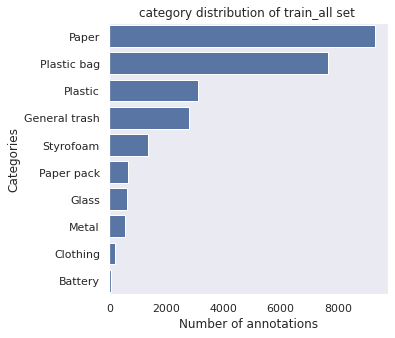

In [16]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train_all set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [17]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [18]:
# class (Categories) 에 따른 index 확인 (0~10 : 총 11개)
sorted_df

Categories  Number of annotations
0       Backgroud                    NaN
1   General trash                 2782.0
2           Paper                 9311.0
3      Paper pack                  659.0
4           Metal                  562.0
5           Glass                  610.0
6         Plastic                 3090.0
7       Styrofoam                 1343.0
8     Plastic bag                 7643.0
9         Battery                   63.0
10       Clothing                  177.0

## 데이터 전처리 함수 정의 (Dataset)

In [19]:
# # hyuns
import sys
coco = COCO("../input/data/train.json")
image_id = coco.getImgIds(imgIds=0)
image_infos = coco.loadImgs(image_id)[0]
#print(image_infos[0])
import matplotlib.pyplot as plt


loading annotations into memory...
Done (t=3.78s)
creating index...
index created!


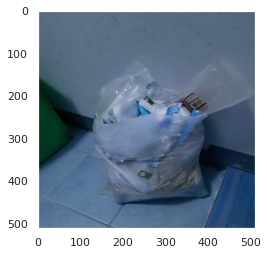

In [20]:

dataset_path_1 = '../input/data/'
images = cv2.imread(os.path.join(dataset_path_1, image_infos['file_name']))
plt.imshow(images)
#print(images)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


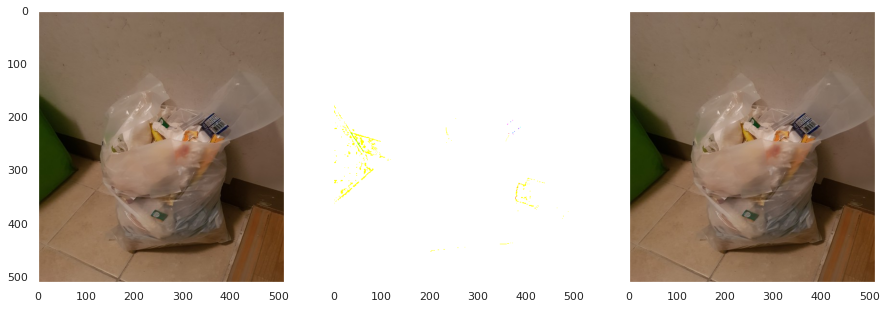

In [21]:

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

images_1 = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.int32)
#plt.imshow(images_1)
ax[0].imshow(images_1, aspect="auto")

images_2 = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
#images_2 /= 255.0
#plt.imshow(images_2)
ax[1].imshow(images_2, aspect="auto")

images_3 = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
images_3 /= 255.0

ax[2].imshow(images_3, aspect="auto")

plt.show()


In [22]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # General trash = 1, ... , Cigarette = 10
            anns = sorted(anns, key=lambda idx : len(idx['segmentation'][0]), reverse=False)
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
                        
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [23]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))


import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                          ToTensorV2()
                          ])

test_transform = A.Compose([
                           ToTensorV2()
                           ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# hyuns

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.77s)
creating index...
index created!
loading annotations into memory...
Done (t=0.77s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


### 데이터 샘플 시각화 (Show example image and mask)

- `train_loader` 
- `val_loader` 
- `test_loader` 

In [24]:
class_colormap = pd.read_csv("class_dict.csv")
class_colormap

name    r    g    b
0       Backgroud    0    0    0
1   General trash  192    0  128
2           Paper    0  128  192
3      Paper pack    0  128   64
4           Metal  128    0    0
5           Glass   64    0  128
6         Plastic   64    0  192
7       Styrofoam  192  128   64
8     Plastic bag  192  192  128
9         Battery   64   64  128
10       Clothing  128    0  192

In [25]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

image shape: [3, 256, 256]
mask shape:  [256, 256]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Paper', 2}, {8, 'Plastic bag'}]


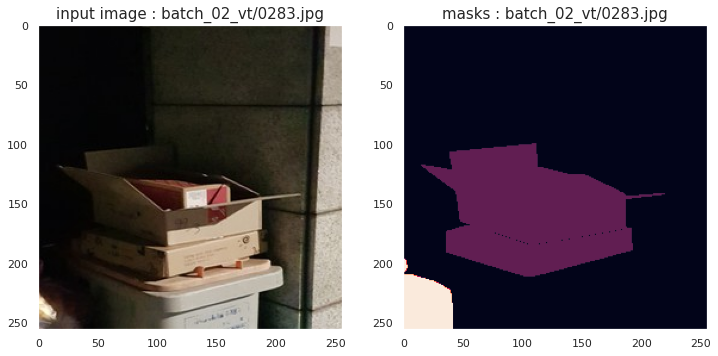

In [26]:
# train_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Glass', 5}, {'Plastic', 6}, {8, 'Plastic bag'}]


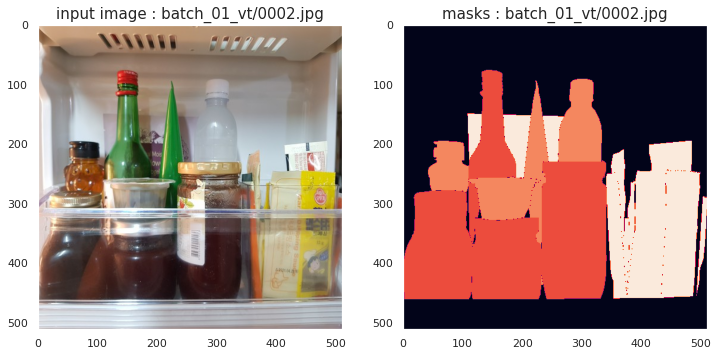

In [27]:
# val_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in val_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))

print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

image shape: [3, 512, 512]


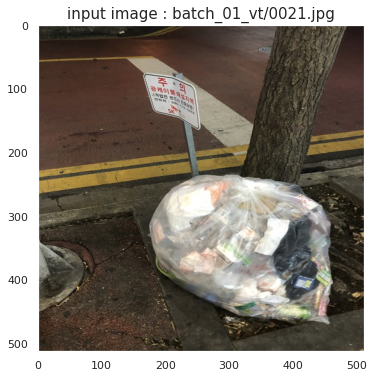

In [28]:
# test_loader의 output 결과(image) 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    
    break

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

print('image shape:', list(temp_images[0].shape))

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

## baseline model

### models.segmentation.fcn_resnet50

In [8]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchsummary

# model = models.segmentation.fcn_resnet50(pretrained=True) # 0.491
# model.classifier[4] = nn.Conv2d(256, 11, kernel_size=1)
# print(model)


In [9]:

model = models.segmentation.deeplabv3_resnet50(pretrained=True)
# output class를 data set에 맞도록 수정
model.classifier[4] = nn.Conv2d(256, 11, kernel_size=1)
#model.aux_classifier[4] =  nn.Conv2d(256, 11, kernel_size=1)
#print(model.aux_classifier)
#torchsummary.summary(model, (3, 64, 64),device='cpu')
# print(model.summary)
#print(model)

In [13]:
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test
x = torch.randn([2, 3, 512, 512])
print(f"input shape : {x.shape}")
out = model(x)['out']
#out = model(x).to(device)
print(f"output shape : {out.size()}")

input shape : torch.Size([2, 3, 512, 512])
output shape : torch.Size([2, 11, 512, 512])


## train, validation, test 함수 정의

In [38]:
import wandb

In [39]:
def loggin_with_wandb(mode, epoch, step, loss, mIOU, acc):
    if mode == "train":
        wandb.log({
                    f"train_epoch": epoch,
                    f"train_step" : step,
                    f"train_loss" : loss,
                    f"train_mIOU" : mIOU,
                    f"train_acc" : acc
                    })
    else:
        wandb.log({
                    f"valid_epoch": epoch,
                    f"valid_step" : step,
                    f"valid_avrg_loss" : loss,
                    f"valid_mIOU" : mIOU,
                    f"valid_acc" : acc
                    })

In [40]:
def train(num_epochs, model, data_loader, val_loader, criterion, optimizer, saved_dir, val_every, device):
    print(f'Start training..')
    n_class = 11
    best_loss = 9999999
    best_mIoU = 0

        # wandb
    run = wandb.init(
    # Set entity to specify your username or team name
    entity="hyunsoo",
    # Set the project where this run will be logged
    project="semantic-segmetation", 
    # Track hyperparameters and run metadata
    group='experiment-1_deeplabv3_resnet50_2_ex',
    name = f"hyuns",
    #job_type="train",
    config={
    "Epoch" : num_epochs, 
    "loss" : "Cross_Entropy",
    "optim" : "Adam",
    "batch_size" : batch_size,
    "learning_rate" : learning_rate
    }
    )
    

    wandb.watch(model)
    
    for epoch in range(num_epochs):
                # wandb
        run = wandb.init(
        # Set entity to specify your username or team name
        entity="hyunsoo",
        # Set the project where this run will be logged
        project="semantic-segmetation", 
        # Track hyperparameters and run metadata
        group='experiment-3_Unet++_mIoU',
        name = f"epoch_{epoch}",
        config={
        "Epoch" : epoch, 
        "loss" : "Cross_Entropy",
        "optim" : "Adam",
        "batch_size" : batch_size,
        "learning_rate" : learning_rate
        }
        )
        wandb.watch(model)
        model.train()

        hist = np.zeros((n_class, n_class))
        for step, (images, masks, _) in enumerate(data_loader):
            images = torch.stack(images)       
            masks = torch.stack(masks).long() 
            
            # gpu 연산을 위해 device 할당
            images, masks = images.to(device), masks.to(device)
            
            # device 할당
            model = model.to(device)
            
            # inference
            outputs = model(images)['out']
            
            # loss 계산 (cross entropy loss)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            masks = masks.detach().cpu().numpy()
            
            #print(masks.shape, outputs.shape, hist.shape)
            hist = add_hist(hist, masks, outputs, n_class=n_class)
            acc, acc_cls, mIoU, fwavacc, IoU = label_accuracy_score(hist)


            
            # step 주기에 따른 loss 출력
            if (step + 1) % 25 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{len(train_loader)}], \
                        Loss: {round(loss.item(),4)}, mIoU: {round(mIoU,4)}')


            loggin_with_wandb("train", epoch, step, round(loss.item(),4), round(mIoU,4), acc)
             
        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % val_every == 0:
            avrg_loss, val_mIoU = validation(epoch + 1, model, val_loader, criterion, device)
            #if avrg_loss < best_loss:
            if val_mIoU > best_mIoU:
                print(f"Best performance at epoch: {epoch + 1}")
                print(f"Save model in {saved_dir}")
                #best_loss = avrg_loss
                best_mIoU = val_mIoU
                wandb.log({"best_mIoU" : best_mIoU})
                #wandb.log({"best_loss" : best_loss})
                save_model(model, saved_dir)
        run.finish()

In [41]:
def validation(epoch, model, data_loader, criterion, device):
    print(f'Start validation #{epoch}')
    model.eval()

    with torch.no_grad():
        n_class = 11
        total_loss = 0
        cnt = 0
        
        hist = np.zeros((n_class, n_class))
        for step, (images, masks, _) in enumerate(data_loader):
            
            images = torch.stack(images)       
            masks = torch.stack(masks).long()  

            images, masks = images.to(device), masks.to(device)            
            
            # device 할당
            model = model.to(device)
            
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            masks = masks.detach().cpu().numpy()
            
            hist = add_hist(hist, masks, outputs, n_class=n_class)
            #acc, acc_cls, mIoU, fwavacc, IoU = label_accuracy_score(hist)
        
        acc, acc_cls, mIoU, fwavacc, IoU = label_accuracy_score(hist)
        loggin_with_wandb("valid", epoch, len(data_loader), round(loss.item(),4), round(mIoU,4), acc)
        IoU_by_class = [{classes : round(IoU,4)} for IoU, classes in zip(IoU , sorted_df['Categories'])]

        wandb.log({list(IoU_by_class[i].keys())[0] : list(IoU_by_class[i].values())[0] for i in range(len(IoU_by_class))})

        avrg_loss = total_loss / cnt
        print(f'Validation #{epoch}  Average Loss: {round(avrg_loss.item(), 4)}, Accuracy : {round(acc, 4)}, \
                mIoU: {round(mIoU, 4)}')
        print(f'IoU by class : {IoU_by_class}')
        
    return avrg_loss, mIoU

## 모델 저장 함수 정의

In [42]:
# 모델 저장 함수 정의
val_every = 1

saved_dir = './saved'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)

def save_model(model, saved_dir, file_name='deeplabv3_resnet50(pretrained)_2.pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model, output_path)

## 모델 생성 및 Loss function, Optimizer 정의

In [43]:
# Loss function 정의
criterion = nn.CrossEntropyLoss()

# Optimizer 정의
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)

In [44]:
train(num_epochs, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Start training..


wandb: Currently logged in as: hyunsoo (use `wandb login --relogin` to force relogin)


Epoch [1/20], Step [25/164],                         Loss: 1.4968, mIoU: 0.1475
Epoch [1/20], Step [50/164],                         Loss: 1.0547, mIoU: 0.172
Epoch [1/20], Step [75/164],                         Loss: 1.2209, mIoU: 0.184
Epoch [1/20], Step [100/164],                         Loss: 0.9036, mIoU: 0.1929
Epoch [1/20], Step [125/164],                         Loss: 0.8599, mIoU: 0.2057
Epoch [1/20], Step [150/164],                         Loss: 1.036, mIoU: 0.213
Start validation #1
Validation #1  Average Loss: 0.5776, Accuracy : 0.8728,                 mIoU: 0.2844
IoU by class : [{'Backgroud': 0.9174}, {'General trash': 0.2091}, {'Paper': 0.593}, {'Paper pack': 0.0}, {'Metal': 0.0}, {'Glass': 0.0002}, {'Plastic': 0.2358}, {'Styrofoam': 0.4186}, {'Plastic bag': 0.7543}, {'Battery': 0.0}, {'Clothing': 0.0}]
Best performance at epoch: 1
Save model in ./saved


Epoch [2/20], Step [25/164],                         Loss: 0.6826, mIoU: 0.2609
Epoch [2/20], Step [50/164],                         Loss: 0.6764, mIoU: 0.2843
Epoch [2/20], Step [75/164],                         Loss: 0.6836, mIoU: 0.2802
Epoch [2/20], Step [100/164],                         Loss: 0.8954, mIoU: 0.2862
Epoch [2/20], Step [125/164],                         Loss: 0.7667, mIoU: 0.2895
Epoch [2/20], Step [150/164],                         Loss: 0.8158, mIoU: 0.2863
Start validation #2
Validation #2  Average Loss: 0.4572, Accuracy : 0.8822,                 mIoU: 0.3452
IoU by class : [{'Backgroud': 0.9238}, {'General trash': 0.298}, {'Paper': 0.6192}, {'Paper pack': 0.0}, {'Metal': 0.0487}, {'Glass': 0.3939}, {'Plastic': 0.2441}, {'Styrofoam': 0.5151}, {'Plastic bag': 0.7549}, {'Battery': 0.0}, {'Clothing': 0.0}]
Best performance at epoch: 2
Save model in ./saved


Epoch [3/20], Step [25/164],                         Loss: 0.6595, mIoU: 0.364
Epoch [3/20], Step [50/164],                         Loss: 0.5882, mIoU: 0.345
Epoch [3/20], Step [75/164],                         Loss: 0.5605, mIoU: 0.3438
Epoch [3/20], Step [100/164],                         Loss: 0.6818, mIoU: 0.3423
Epoch [3/20], Step [125/164],                         Loss: 0.6739, mIoU: 0.3442
Epoch [3/20], Step [150/164],                         Loss: 0.444, mIoU: 0.3464
Start validation #3
Validation #3  Average Loss: 0.4045, Accuracy : 0.891,                 mIoU: 0.3708
IoU by class : [{'Backgroud': 0.9298}, {'General trash': 0.3285}, {'Paper': 0.6496}, {'Paper pack': 0.0596}, {'Metal': 0.0905}, {'Glass': 0.4122}, {'Plastic': 0.2674}, {'Styrofoam': 0.5572}, {'Plastic bag': 0.7701}, {'Battery': 0.0}, {'Clothing': 0.0137}]
Best performance at epoch: 3
Save model in ./saved


Epoch [4/20], Step [25/164],                         Loss: 0.4074, mIoU: 0.387
Epoch [4/20], Step [50/164],                         Loss: 0.5156, mIoU: 0.3826
Epoch [4/20], Step [75/164],                         Loss: 0.3843, mIoU: 0.3796
Epoch [4/20], Step [100/164],                         Loss: 0.671, mIoU: 0.3805
Epoch [4/20], Step [125/164],                         Loss: 0.3888, mIoU: 0.378
Epoch [4/20], Step [150/164],                         Loss: 0.5554, mIoU: 0.3818
Start validation #4
Validation #4  Average Loss: 0.3838, Accuracy : 0.89,                 mIoU: 0.3771
IoU by class : [{'Backgroud': 0.927}, {'General trash': 0.3453}, {'Paper': 0.6458}, {'Paper pack': 0.015}, {'Metal': 0.2881}, {'Glass': 0.4615}, {'Plastic': 0.1851}, {'Styrofoam': 0.5356}, {'Plastic bag': 0.7445}, {'Battery': 0.0}, {'Clothing': 0.0005}]
Best performance at epoch: 4
Save model in ./saved


Epoch [5/20], Step [25/164],                         Loss: 0.3595, mIoU: 0.4553
Epoch [5/20], Step [50/164],                         Loss: 0.6053, mIoU: 0.4507
Epoch [5/20], Step [75/164],                         Loss: 0.4294, mIoU: 0.4342
Epoch [5/20], Step [100/164],                         Loss: 0.5602, mIoU: 0.4295
Epoch [5/20], Step [125/164],                         Loss: 0.6294, mIoU: 0.431
Epoch [5/20], Step [150/164],                         Loss: 0.4258, mIoU: 0.4331
Start validation #5
Validation #5  Average Loss: 0.3728, Accuracy : 0.8883,                 mIoU: 0.3972
IoU by class : [{'Backgroud': 0.9249}, {'General trash': 0.3584}, {'Paper': 0.6022}, {'Paper pack': 0.1526}, {'Metal': 0.1078}, {'Glass': 0.4426}, {'Plastic': 0.2726}, {'Styrofoam': 0.5535}, {'Plastic bag': 0.7714}, {'Battery': 0.0}, {'Clothing': 0.1826}]
Best performance at epoch: 5
Save model in ./saved


Epoch [6/20], Step [25/164],                         Loss: 0.4975, mIoU: 0.4412
Epoch [6/20], Step [50/164],                         Loss: 0.4484, mIoU: 0.449
Epoch [6/20], Step [75/164],                         Loss: 0.3697, mIoU: 0.449
Epoch [6/20], Step [100/164],                         Loss: 0.442, mIoU: 0.4559
Epoch [6/20], Step [125/164],                         Loss: 0.4932, mIoU: 0.4509
Epoch [6/20], Step [150/164],                         Loss: 0.6668, mIoU: 0.4506
Start validation #6
Validation #6  Average Loss: 0.3391, Accuracy : 0.9006,                 mIoU: 0.4306
IoU by class : [{'Backgroud': 0.9306}, {'General trash': 0.3339}, {'Paper': 0.6497}, {'Paper pack': 0.1555}, {'Metal': 0.2788}, {'Glass': 0.3928}, {'Plastic': 0.3465}, {'Styrofoam': 0.554}, {'Plastic bag': 0.7797}, {'Battery': 0.0}, {'Clothing': 0.3156}]
Best performance at epoch: 6
Save model in ./saved


Epoch [7/20], Step [25/164],                         Loss: 0.4493, mIoU: 0.5262
Epoch [7/20], Step [50/164],                         Loss: 0.666, mIoU: 0.4992
Epoch [7/20], Step [75/164],                         Loss: 0.2516, mIoU: 0.4877
Epoch [7/20], Step [100/164],                         Loss: 0.4834, mIoU: 0.4865
Epoch [7/20], Step [125/164],                         Loss: 0.5494, mIoU: 0.4841
Epoch [7/20], Step [150/164],                         Loss: 0.545, mIoU: 0.4824
Start validation #7
Validation #7  Average Loss: 0.3444, Accuracy : 0.8989,                 mIoU: 0.4125
IoU by class : [{'Backgroud': 0.931}, {'General trash': 0.3649}, {'Paper': 0.6547}, {'Paper pack': 0.2671}, {'Metal': 0.147}, {'Glass': 0.3789}, {'Plastic': 0.2728}, {'Styrofoam': 0.4963}, {'Plastic bag': 0.7838}, {'Battery': 0.0}, {'Clothing': 0.2408}]


Epoch [8/20], Step [25/164],                         Loss: 0.5772, mIoU: 0.5127
Epoch [8/20], Step [50/164],                         Loss: 0.4127, mIoU: 0.5159
Epoch [8/20], Step [75/164],                         Loss: 0.6658, mIoU: 0.5044
Epoch [8/20], Step [100/164],                         Loss: 0.333, mIoU: 0.5034
Epoch [8/20], Step [125/164],                         Loss: 0.3397, mIoU: 0.5059
Epoch [8/20], Step [150/164],                         Loss: 0.3315, mIoU: 0.5101
Start validation #8
Validation #8  Average Loss: 0.3271, Accuracy : 0.9044,                 mIoU: 0.4549
IoU by class : [{'Backgroud': 0.9328}, {'General trash': 0.3658}, {'Paper': 0.671}, {'Paper pack': 0.3618}, {'Metal': 0.272}, {'Glass': 0.4807}, {'Plastic': 0.3324}, {'Styrofoam': 0.5485}, {'Plastic bag': 0.792}, {'Battery': 0.0}, {'Clothing': 0.2474}]
Best performance at epoch: 8
Save model in ./saved


Epoch [9/20], Step [25/164],                         Loss: 0.3667, mIoU: 0.5756
Epoch [9/20], Step [50/164],                         Loss: 0.7048, mIoU: 0.5778
Epoch [9/20], Step [75/164],                         Loss: 0.533, mIoU: 0.5564
Epoch [9/20], Step [100/164],                         Loss: 0.6432, mIoU: 0.5445
Epoch [9/20], Step [125/164],                         Loss: 0.4221, mIoU: 0.5322
Epoch [9/20], Step [150/164],                         Loss: 0.325, mIoU: 0.5319
Start validation #9
Validation #9  Average Loss: 0.3666, Accuracy : 0.8889,                 mIoU: 0.3887
IoU by class : [{'Backgroud': 0.9287}, {'General trash': 0.3161}, {'Paper': 0.6121}, {'Paper pack': 0.2913}, {'Metal': 0.123}, {'Glass': 0.4987}, {'Plastic': 0.3052}, {'Styrofoam': 0.3217}, {'Plastic bag': 0.7385}, {'Battery': 0.0}, {'Clothing': 0.1409}]


Epoch [10/20], Step [25/164],                         Loss: 0.3895, mIoU: 0.577
Epoch [10/20], Step [50/164],                         Loss: 0.3477, mIoU: 0.5658
Epoch [10/20], Step [75/164],                         Loss: 0.4086, mIoU: 0.5566
Epoch [10/20], Step [100/164],                         Loss: 0.2967, mIoU: 0.5627
Epoch [10/20], Step [125/164],                         Loss: 0.4252, mIoU: 0.5566
Epoch [10/20], Step [150/164],                         Loss: 0.7975, mIoU: 0.554
Start validation #10
Validation #10  Average Loss: 0.3214, Accuracy : 0.9023,                 mIoU: 0.4503
IoU by class : [{'Backgroud': 0.9336}, {'General trash': 0.3553}, {'Paper': 0.6413}, {'Paper pack': 0.3624}, {'Metal': 0.3217}, {'Glass': 0.4849}, {'Plastic': 0.3474}, {'Styrofoam': 0.5342}, {'Plastic bag': 0.7753}, {'Battery': 0.0}, {'Clothing': 0.1975}]


Epoch [11/20], Step [25/164],                         Loss: 0.2928, mIoU: 0.4867
Epoch [11/20], Step [50/164],                         Loss: 0.2226, mIoU: 0.5165
Epoch [11/20], Step [75/164],                         Loss: 0.5037, mIoU: 0.5314
Epoch [11/20], Step [100/164],                         Loss: 0.3908, mIoU: 0.5398
Epoch [11/20], Step [125/164],                         Loss: 0.3134, mIoU: 0.5376
Epoch [11/20], Step [150/164],                         Loss: 0.2849, mIoU: 0.537
Start validation #11
Validation #11  Average Loss: 0.3336, Accuracy : 0.8974,                 mIoU: 0.4383
IoU by class : [{'Backgroud': 0.9313}, {'General trash': 0.3455}, {'Paper': 0.6418}, {'Paper pack': 0.312}, {'Metal': 0.274}, {'Glass': 0.4284}, {'Plastic': 0.3299}, {'Styrofoam': 0.5801}, {'Plastic bag': 0.758}, {'Battery': 0.0}, {'Clothing': 0.2205}]


Epoch [12/20], Step [25/164],                         Loss: 0.3867, mIoU: 0.608
Epoch [12/20], Step [50/164],                         Loss: 0.6222, mIoU: 0.5931
Epoch [12/20], Step [75/164],                         Loss: 0.2681, mIoU: 0.5931
Epoch [12/20], Step [100/164],                         Loss: 0.3561, mIoU: 0.5858
Epoch [12/20], Step [125/164],                         Loss: 0.2563, mIoU: 0.5878
Epoch [12/20], Step [150/164],                         Loss: 0.352, mIoU: 0.5825
Start validation #12
Validation #12  Average Loss: 0.3149, Accuracy : 0.9038,                 mIoU: 0.4524
IoU by class : [{'Backgroud': 0.9342}, {'General trash': 0.3611}, {'Paper': 0.6644}, {'Paper pack': 0.3548}, {'Metal': 0.3403}, {'Glass': 0.4625}, {'Plastic': 0.3461}, {'Styrofoam': 0.5113}, {'Plastic bag': 0.7717}, {'Battery': 0.0}, {'Clothing': 0.2304}]


Epoch [13/20], Step [25/164],                         Loss: 0.327, mIoU: 0.572
Epoch [13/20], Step [50/164],                         Loss: 0.2637, mIoU: 0.5853
Epoch [13/20], Step [75/164],                         Loss: 0.413, mIoU: 0.5819
Epoch [13/20], Step [100/164],                         Loss: 0.3678, mIoU: 0.5845
Epoch [13/20], Step [125/164],                         Loss: 0.4075, mIoU: 0.5896
Epoch [13/20], Step [150/164],                         Loss: 0.3706, mIoU: 0.592
Start validation #13
Validation #13  Average Loss: 0.2963, Accuracy : 0.9099,                 mIoU: 0.4665
IoU by class : [{'Backgroud': 0.9388}, {'General trash': 0.3993}, {'Paper': 0.6829}, {'Paper pack': 0.3472}, {'Metal': 0.2512}, {'Glass': 0.4692}, {'Plastic': 0.3465}, {'Styrofoam': 0.5928}, {'Plastic bag': 0.7976}, {'Battery': 0.0}, {'Clothing': 0.3057}]
Best performance at epoch: 13
Save model in ./saved


Epoch [14/20], Step [25/164],                         Loss: 0.4307, mIoU: 0.6203
Epoch [14/20], Step [50/164],                         Loss: 0.2901, mIoU: 0.6197
Epoch [14/20], Step [75/164],                         Loss: 0.2581, mIoU: 0.6345
Epoch [14/20], Step [100/164],                         Loss: 0.286, mIoU: 0.6297
Epoch [14/20], Step [125/164],                         Loss: 0.3667, mIoU: 0.6194
Epoch [14/20], Step [150/164],                         Loss: 0.2837, mIoU: 0.6249
Start validation #14
Validation #14  Average Loss: 0.3347, Accuracy : 0.9025,                 mIoU: 0.4261
IoU by class : [{'Backgroud': 0.9318}, {'General trash': 0.3673}, {'Paper': 0.6703}, {'Paper pack': 0.1954}, {'Metal': 0.1895}, {'Glass': 0.3718}, {'Plastic': 0.3631}, {'Styrofoam': 0.6362}, {'Plastic bag': 0.7729}, {'Battery': 0.0}, {'Clothing': 0.1887}]


Epoch [15/20], Step [25/164],                         Loss: 0.5235, mIoU: 0.6127
Epoch [15/20], Step [50/164],                         Loss: 0.2233, mIoU: 0.6162
Epoch [15/20], Step [75/164],                         Loss: 0.2752, mIoU: 0.6373
Epoch [15/20], Step [100/164],                         Loss: 0.2735, mIoU: 0.6252
Epoch [15/20], Step [125/164],                         Loss: 0.2794, mIoU: 0.6242
Epoch [15/20], Step [150/164],                         Loss: 0.3308, mIoU: 0.6277
Start validation #15
Validation #15  Average Loss: 0.3029, Accuracy : 0.9074,                 mIoU: 0.4528
IoU by class : [{'Backgroud': 0.9391}, {'General trash': 0.3487}, {'Paper': 0.6668}, {'Paper pack': 0.3473}, {'Metal': 0.2335}, {'Glass': 0.433}, {'Plastic': 0.3612}, {'Styrofoam': 0.6274}, {'Plastic bag': 0.7896}, {'Battery': 0.0}, {'Clothing': 0.234}]


Epoch [16/20], Step [25/164],                         Loss: 0.455, mIoU: 0.7091
Epoch [16/20], Step [50/164],                         Loss: 0.4251, mIoU: 0.6582
Epoch [16/20], Step [75/164],                         Loss: 0.1687, mIoU: 0.659
Epoch [16/20], Step [100/164],                         Loss: 0.4823, mIoU: 0.6522
Epoch [16/20], Step [125/164],                         Loss: 0.4674, mIoU: 0.6487
Epoch [16/20], Step [150/164],                         Loss: 0.2296, mIoU: 0.6334
Start validation #16
Validation #16  Average Loss: 0.3691, Accuracy : 0.8911,                 mIoU: 0.3908
IoU by class : [{'Backgroud': 0.9295}, {'General trash': 0.2695}, {'Paper': 0.6543}, {'Paper pack': 0.1373}, {'Metal': 0.1906}, {'Glass': 0.4463}, {'Plastic': 0.2708}, {'Styrofoam': 0.3859}, {'Plastic bag': 0.7353}, {'Battery': 0.0}, {'Clothing': 0.2797}]


Epoch [17/20], Step [25/164],                         Loss: 0.315, mIoU: 0.6098
Epoch [17/20], Step [50/164],                         Loss: 0.2634, mIoU: 0.6117
Epoch [17/20], Step [75/164],                         Loss: 0.2595, mIoU: 0.6278
Epoch [17/20], Step [100/164],                         Loss: 0.4306, mIoU: 0.6366
Epoch [17/20], Step [125/164],                         Loss: 0.3427, mIoU: 0.639
Epoch [17/20], Step [150/164],                         Loss: 0.2977, mIoU: 0.6402
Start validation #17
Validation #17  Average Loss: 0.31, Accuracy : 0.9076,                 mIoU: 0.4702
IoU by class : [{'Backgroud': 0.9372}, {'General trash': 0.3812}, {'Paper': 0.6801}, {'Paper pack': 0.3772}, {'Metal': 0.2594}, {'Glass': 0.4685}, {'Plastic': 0.3468}, {'Styrofoam': 0.616}, {'Plastic bag': 0.7959}, {'Battery': 0.0}, {'Clothing': 0.3094}]
Best performance at epoch: 17
Save model in ./saved


Epoch [18/20], Step [25/164],                         Loss: 0.2488, mIoU: 0.6204
Epoch [18/20], Step [50/164],                         Loss: 0.254, mIoU: 0.6375
Epoch [18/20], Step [75/164],                         Loss: 0.2922, mIoU: 0.6418
Epoch [18/20], Step [100/164],                         Loss: 0.2616, mIoU: 0.644
Epoch [18/20], Step [125/164],                         Loss: 0.3319, mIoU: 0.6477
Epoch [18/20], Step [150/164],                         Loss: 0.3536, mIoU: 0.6536
Start validation #18
Validation #18  Average Loss: 0.3108, Accuracy : 0.9058,                 mIoU: 0.4743
IoU by class : [{'Backgroud': 0.9342}, {'General trash': 0.351}, {'Paper': 0.6609}, {'Paper pack': 0.4218}, {'Metal': 0.3652}, {'Glass': 0.4954}, {'Plastic': 0.3477}, {'Styrofoam': 0.653}, {'Plastic bag': 0.774}, {'Battery': 0.0}, {'Clothing': 0.2142}]
Best performance at epoch: 18
Save model in ./saved


Epoch [19/20], Step [25/164],                         Loss: 0.4154, mIoU: 0.6657
Epoch [19/20], Step [50/164],                         Loss: 0.2547, mIoU: 0.6576
Epoch [19/20], Step [75/164],                         Loss: 0.3402, mIoU: 0.6574
Epoch [19/20], Step [100/164],                         Loss: 0.2785, mIoU: 0.6584
Epoch [19/20], Step [125/164],                         Loss: 0.2867, mIoU: 0.6544
Epoch [19/20], Step [150/164],                         Loss: 0.4517, mIoU: 0.6523
Start validation #19
Validation #19  Average Loss: 0.3134, Accuracy : 0.9074,                 mIoU: 0.4793
IoU by class : [{'Backgroud': 0.932}, {'General trash': 0.33}, {'Paper': 0.6715}, {'Paper pack': 0.4253}, {'Metal': 0.3015}, {'Glass': 0.5007}, {'Plastic': 0.4192}, {'Styrofoam': 0.6465}, {'Plastic bag': 0.7721}, {'Battery': 0.0}, {'Clothing': 0.2735}]
Best performance at epoch: 19
Save model in ./saved


Epoch [20/20], Step [25/164],                         Loss: 0.2123, mIoU: 0.7232
Epoch [20/20], Step [50/164],                         Loss: 0.1123, mIoU: 0.6612
Epoch [20/20], Step [75/164],                         Loss: 0.301, mIoU: 0.647
Epoch [20/20], Step [100/164],                         Loss: 0.2957, mIoU: 0.6546
Epoch [20/20], Step [125/164],                         Loss: 0.2218, mIoU: 0.6532
Epoch [20/20], Step [150/164],                         Loss: 0.2185, mIoU: 0.6563
Start validation #20
Validation #20  Average Loss: 0.3121, Accuracy : 0.9084,                 mIoU: 0.439
IoU by class : [{'Backgroud': 0.9337}, {'General trash': 0.3368}, {'Paper': 0.673}, {'Paper pack': 0.2396}, {'Metal': 0.3376}, {'Glass': 0.3982}, {'Plastic': 0.3902}, {'Styrofoam': 0.6293}, {'Plastic bag': 0.7916}, {'Battery': 0.0}, {'Clothing': 0.0987}]


## 저장된 model 불러오기 (학습된 이후) 

In [55]:
# best model 저장된 경로
model_path = './saved/deeplabv3_resnet50(pretrained)_2.pt'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint.state_dict()
model.load_state_dict(state_dict)

model = model.to(device)
# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
# model.eval()

### `plot_examples()` 시각화 함수 정의

In [56]:
def plot_examples(mode="train", batch_id=0, num_examples=batch_size, dataloaer=train_loader):
    """Visualization of images and masks according to batch size
    Args:
        mode: train/val/test (str)
        batch_id : 0 (int) 
        num_examples : 1 ~ batch_size(e.g. 8) (int)
        dataloaer : data_loader (dataloader) 
    Returns:
        None
    """
    # variable for legend
    category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                             edgecolor=webcolors.rgb_to_hex(rgb), 
                             label=category) for category, rgb in category_and_rgb]
    
    # test / validation set에 대한 시각화
    if (mode in ('train', 'val')):
        with torch.no_grad():
            for index, (imgs, masks, image_infos) in enumerate(dataloaer):
                if index == batch_id:
                    image_infos = image_infos
                    temp_images = imgs
                    temp_masks = masks

                    model.eval()
                    # inference
                    outs = model(torch.stack(temp_images).to(device))['out']
                    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()

                    break
                else:
                    continue
    
        fig, ax = plt.subplots(nrows=num_examples, ncols=3, figsize=(12, 4*num_examples), constrained_layout=True)
        fig.tight_layout()
        for row_num in range(num_examples):
            # Original Image
            ax[row_num][0].imshow(temp_images[row_num].permute([1,2,0]))
            ax[row_num][0].set_title(f"Orignal Image : {image_infos[row_num]['file_name']}")
            # Groud Truth
            ax[row_num][1].imshow(label_to_color_image(masks[row_num].detach().cpu().numpy()))
            ax[row_num][1].set_title(f"Groud Truth : {image_infos[row_num]['file_name']}")
            # Pred Mask
            ax[row_num][2].imshow(label_to_color_image(oms[row_num]))
            ax[row_num][2].set_title(f"Pred Mask : {image_infos[row_num]['file_name']}")
            ax[row_num][2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
        plt.show()
    
    # test set에 대한 시각화
    else :
        with torch.no_grad():
            for index, (imgs, image_infos) in enumerate(dataloaer):
                if index == batch_id:
                    image_infos = image_infos
                    temp_images = imgs

                    model.eval()
                    
                    # inference
                    outs = model(torch.stack(temp_images).to(device))['out']
                    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()
                    break
                else:
                    continue
    
        fig, ax = plt.subplots(nrows=num_examples, ncols=2, figsize=(10, 4*num_examples), constrained_layout=True)

        for row_num in range(num_examples):
            # Original Image
            ax[row_num][0].imshow(temp_images[row_num].permute([1,2,0]))
            ax[row_num][0].set_title(f"Orignal Image : {image_infos[row_num]['file_name']}")
            # Pred Mask
            ax[row_num][1].imshow(label_to_color_image(oms[row_num]))
            ax[row_num][1].set_title(f"Pred Mask : {image_infos[row_num]['file_name']}")
            ax[row_num][1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
            
        plt.show()

#### train set 시각화

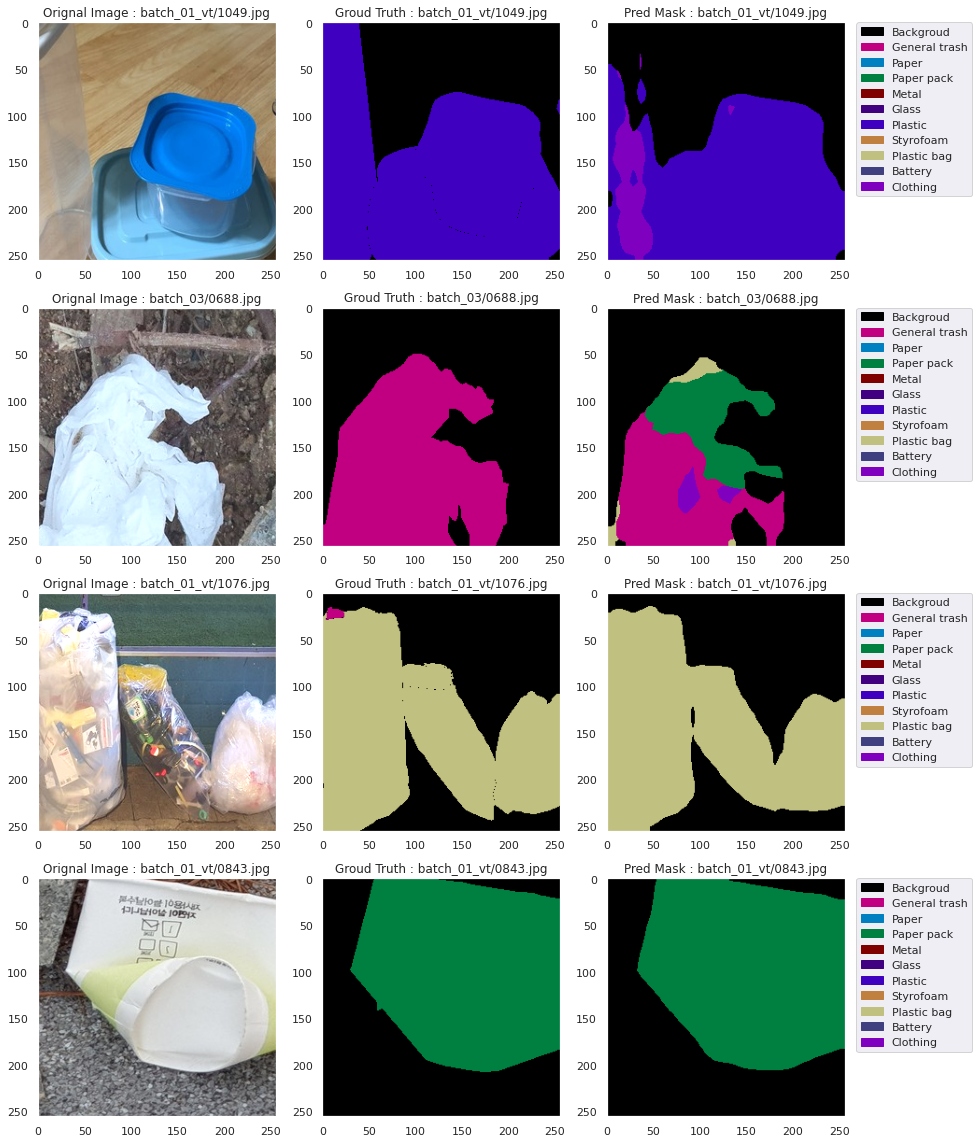

In [58]:
plot_examples(mode="train", batch_id=7, num_examples=4, dataloaer=train_loader)

#### validation set 시각화

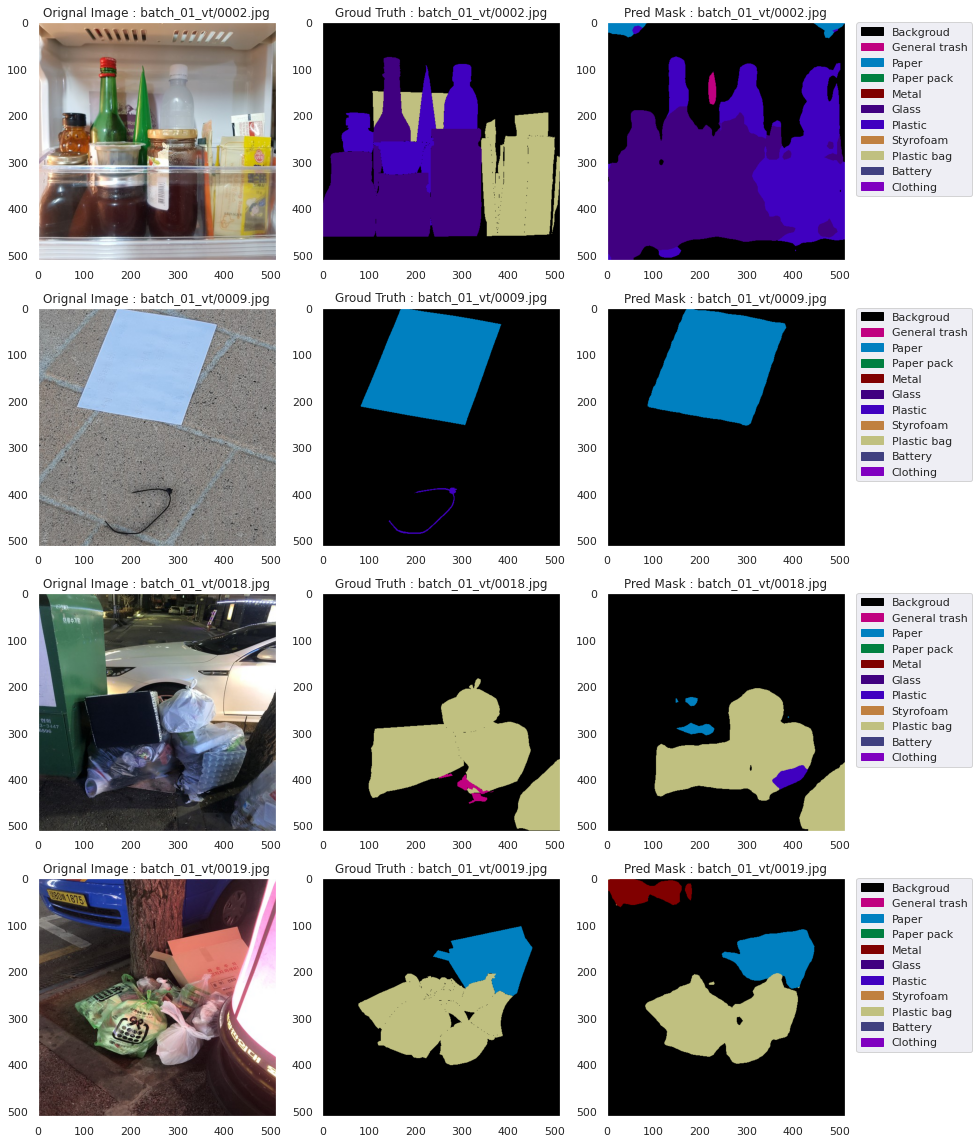

In [59]:
plot_examples(mode="val", batch_id=0, num_examples=4, dataloaer=val_loader)

#### test set 시각화

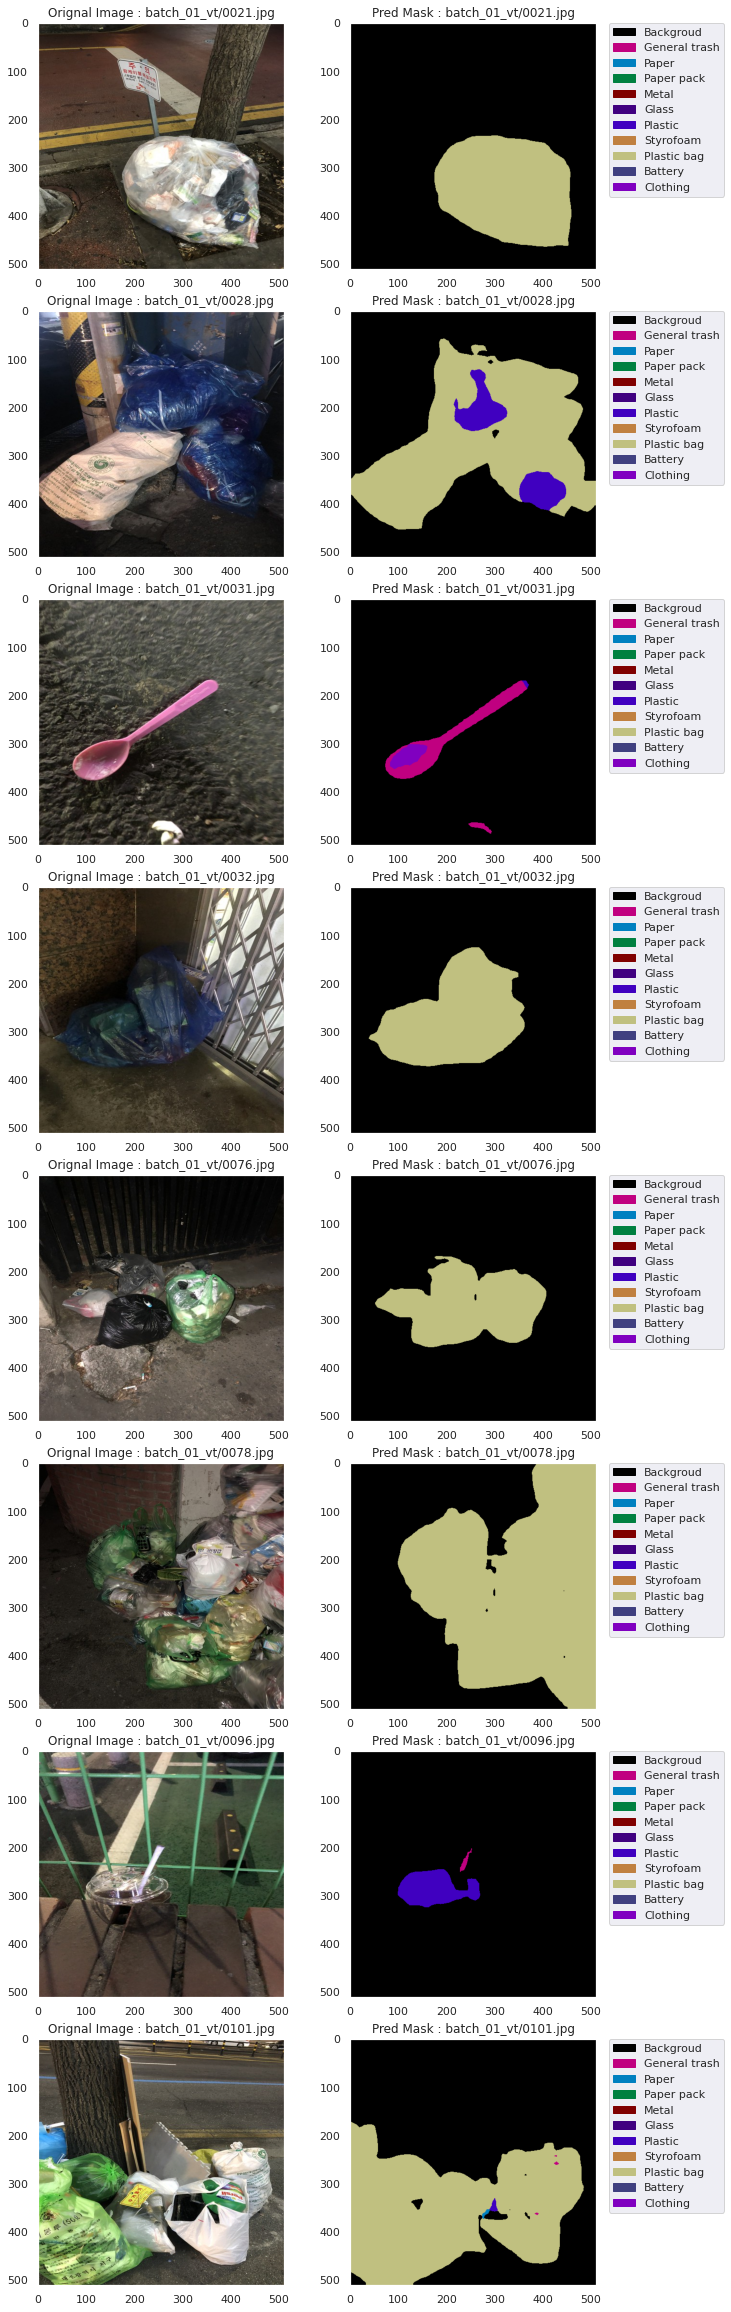

In [60]:
plot_examples(mode="test", batch_id=0, num_examples=8, dataloaer=test_loader)

## submission을 위한 test 함수 정의

In [61]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(size, size)])
    print('Start prediction.')
    
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(tqdm(test_loader)):
            
            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))['out']
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)
                
            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [63]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv("./submission/deeplabv3_resnet50(pretrained)_2.csv", index=False)

  0%|          | 0/52 [00:00<?, ?it/s]

Start prediction.


100%|██████████| 52/52 [06:48<00:00,  6.22s/it]


End prediction.
